# 1. Introduçao

### Cotexto Geral
Nesse case, irei trabalhar em uma comparação entre os índices de Sortino e Sharpe para o Bitcoin.

De forma mais simplória, o índice de sharpe busca fazer uma comparação relativa entre o risco e retorno de um investimento e um investimento livre de risco. Dessa forma, esse índice é usualmente calculado da segguinte maneira:

\begin{equation}
Sharpe=\frac{({R_i} - {R_f})}{\sigma_i}
\end{equation}

Na qual $R_i$ é o retorno do investimento, $R_f$ é retorno livre de risco e $\sigma_i$ é o risco (a volatilidade) do ativo.

Em contrapartida, temos também o Índice de Sortino, que é basicamente uma variação do índice de Sharpe, porém neste último, nós iremos considerar apenas a volatilidade negativa do nosso ativo. Para isso, teremos que reestruturar nossa equação para o seguinte formato:

\begin{equation}
Sortino=\frac{({R_i} - {R_f})}{\sigma_n}
\end{equation}

Nota-se que aqui a única diferença é que o termo $\sigma_i$ do índice sharpe, agora passa a ser $\sigma_n$, indicando que estamos olhando apenas para a volatilidade negativa.

### Desenvolvimento

Para melhor entendimento, irei buscar informações sobre o bitcoin e, em seguida, vou calcular tanto o sharpe quanto o sortino em uma janela de tempo específica.

Esses insumos me permitirão entender melhor sobre o comportamento de cada um desses indicadores e um ativo extremamente volátil como o Bitcoin. O que buscamos aqui vai ser entender o comportamento de cada um desses índices e em qual ocasião poderemos utilizar cada um deles de forma mais eficiente.

# 2. Importando as bibliotecas e obtendo os dados.

## 2.1. Importando as bibliotecas

Aqui irei trazer as bibliotecas que vão me auxiliar nesse estudo de caso. A princípio, eu as utilizarei para:
* Análise de dados;
* Métricas Financeiras;
* Plotar Gráficos.

In [1]:

import numpy as np
import pandas as pd
import yfinance as yf
import quantstats as qs
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

## 2.2. Obtendo os dados

Irei importar as informações do Bitcoin, trazendo os dados de fechamendo do dia ('Close'). Para ter mais massa de dados, irei iniciar minha análise em 01/01/2018. Para questão de revisão futura, deixarei o csv dessa base em um arquivo separado.

In [2]:
bitcoin_close = yf.download('BTC-USD', start = '2018-01-01')[['Close']]
bitcoin_close.head()

[*********************100%***********************]  1 of 1 completed


,Close
Date,
2018-01-01,13657.200195
2018-01-02,14982.099609
2018-01-03,15201.000000
2018-01-04,15599.200195
2018-01-05,17429.500000


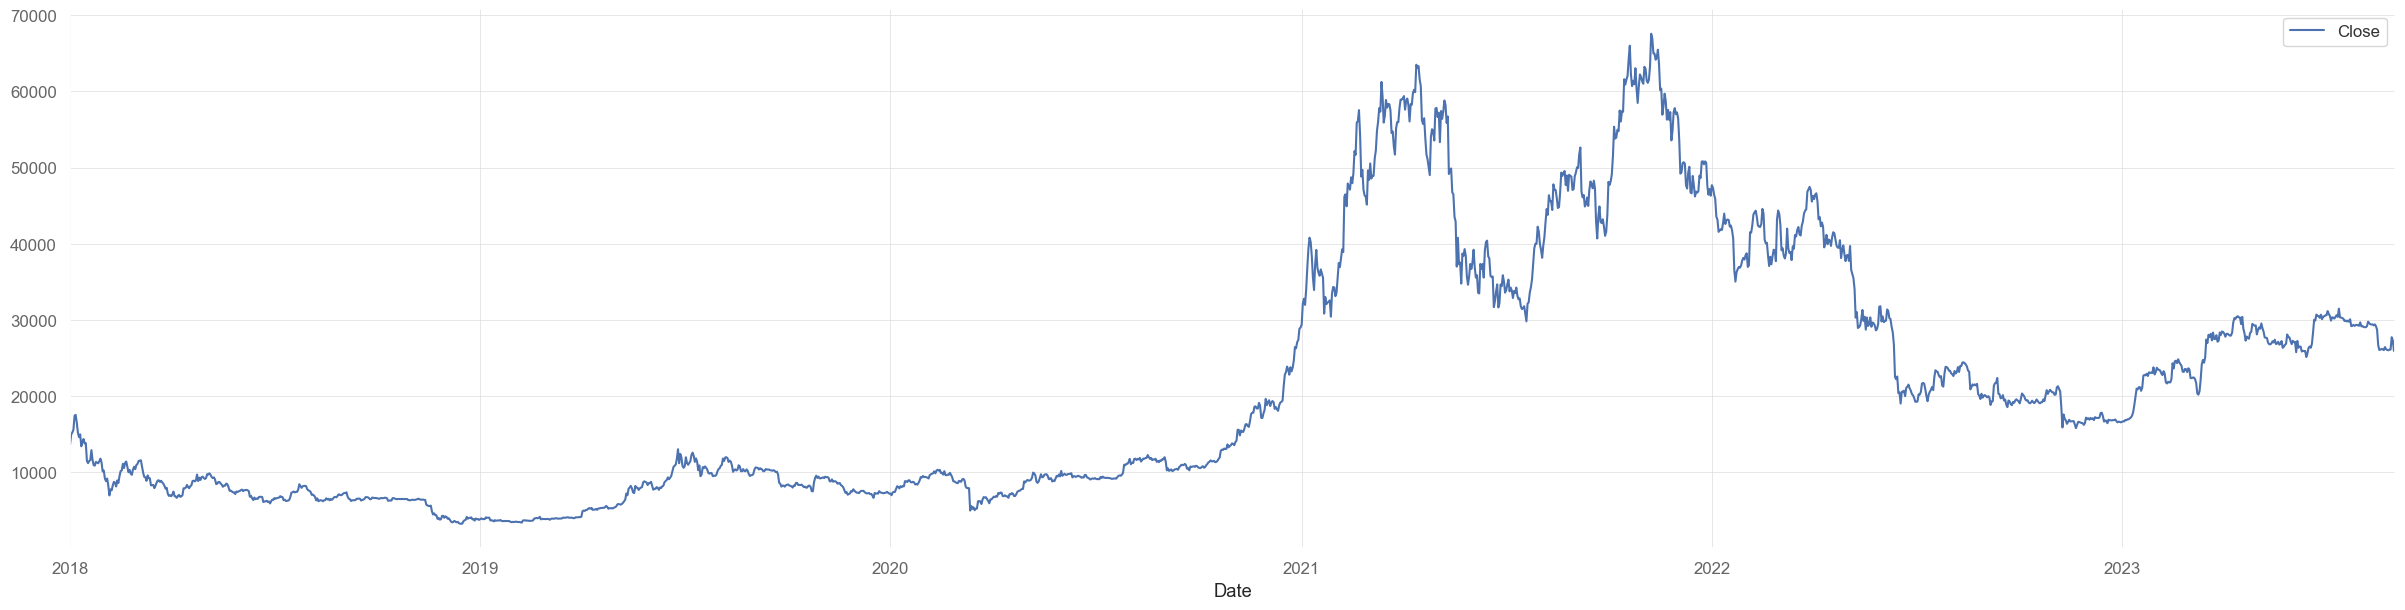

In [3]:
bitcoin_close.plot(figsize=(30,7));

# 3. Análise de métricas

Inicialmente, quero trazer o cálculo do Sharpe e do Sortino. Aqui, devo utilizar a biblioteca quantstats, que já apresenta uma forma fácil de calcular esses indicadores em uma janela de tempo.
A própria biblioteca já assume a janela como sendo um semestre (aproximadamente 126 dias).

Aqui, usarei uma taxa livre de risco de 6%, valor abaixo da metade da selic atual (13,25%).

In [4]:
sharpe_qs = pd.Series(qs.stats.rolling_sharpe(bitcoin_close['Close'], rf = 0.06).values)
sortino_qs = pd.Series(qs.stats.rolling_sortino(bitcoin_close['Close'], rf = 0.06).values)

#Igualando as datas dos índices
sharpe_qs.index = bitcoin_close.index
sortino_qs.index = bitcoin_close.index

Vamos avaliar a correlação entre o Sharpe e o Sortino, ou seja, queremos saber se a relação entre essas duas grandezas é linear ou não, fazendo um gráfico de disperção.

In [5]:
fig_corr = go.Figure()
fig_corr.add_trace({'type': 'scatter',
                    'x': sharpe_qs,
                    'y': sortino_qs,
                    'mode': 'markers',
                    'line': {'color':'blue'}})
fig_corr.update_layout(template='simple_white', paper_bgcolor="#f7f8fa",
                        margin=dict(l=70, r=20, t=20, b=70),
                        xaxis_title='<b>Sharpe', yaxis_title='<b>Sortino',
                        width=500, height=500)

O que vemos aqui é que a curva se aproxima bastante de uma reta, ou seja, entendemos que há uma alta correção entre as variáveis. Portanto, vamos calcular essa correlação:

In [6]:
corr, p = stats.pearsonr(sharpe_qs.dropna(), sortino_qs.dropna())
print('Correlação de Pearson, r=%.3f' %corr, 'p=%.3f' %p)

Correlação de Pearson, r=0.989 p=0.000


Correlação extremamente alta (0.989), validando o que vimos no gráfico anterior e também temos um p-valor muito baixo (menor de 0.000), o que comprova que nossa amostra tem grande relevância estatística.
Portanto, podemos começar a seguir para a conclusão de nosso estudo, baseado na solução acima.

Abaixo iremos comparar os indicadores, porém também iremos fazer uma transformação logarítmica no preço do Bitcoin. Isso será feito porque a variação pode ser extrema demais entre picos e vales e pode acabar nos dando percepções equivocadas sobre as curvas.

In [7]:
fig = make_subplots(specs=[[{'secondary_y': True}]])
fig.add_trace(go.Scatter(x = sharpe_qs.index, y=sharpe_qs, name = 'Sharpe', line= dict(color = 'blue', width = 2)),
              secondary_y=False)
fig.add_trace(go.Scatter(x = sortino_qs.index, y=sortino_qs, name = 'Sortino', line= dict(color = 'red', width = 2)),
              secondary_y=False)
fig.add_trace(go.Scatter(x = bitcoin_close.index, y=np.log(bitcoin_close['Close']), name = 'log price BTC-USD', line= dict(color = 'black', width = 2)),
              secondary_y=True)

fig.update_yaxes(title_text = 'Risk-adjusted values', secondary_y=False)
fig.update_yaxes(title_text = 'log price BTC-USD', secondary_y=True)

fig.update_layout(title='<b>Sharpe vs Sortino ratio', xaxis_title="<b>Data", legend_title="",
                  font=dict(family="Arial, Arial, Arial",size=15,color="black"), template = 'simple_white', paper_bgcolor="#f7f8fa",
                  margin=dict(l=75, r=20, t=70, b=70), legend=dict(orientation="h",yanchor="bottom",y=1,xanchor="right",x=0.4),
                  width=1000,height=500)

# 4. Resultado

Como resultado desse case, notei algumas coisas importantes aqui que serão separadas em 3 pontos:

1. O sortino faz mais sentido quando temos uma tendência de alta, uma vez que ele só irá calcular a volatilidade do drawdown.

2. O sharpe nos mostra a volatilidade em altas e baixas, e se assemelha muito ao sortino nas quedas, porém ele é mais sensível por considerar qualquer tipo de volatilidade.

3. Nesse estudo o Bitcoin está apresentando sortino e sharpe negativos, o que indica que talvez não seja um bom investimento, caso nossa taxa livre de risco (SELIC) esteja em 6%.